# DeepHarmony - Experiments on music genre classification with deep neural networks

Group project for the Deep Learning course held by Prof. Matteo Ferrara.

Group members:


*   Marzoli Leo
*   Nediani Gian Luca
*   Pirazzoli Federico



# Introduction + Context

This project aims to apply the deep learning techniques acquired during the course to the musical domain by training neural networks capable of accurately predicting the genre of given audio tracks. The focus will be on investigating two main aspects:

1. What impact does the duration of audio files have on the network's performance?
2. Is it feasible to segment the available tracks to obtain more examples? What impact does this have on performance compared to using non-segmented songs?

Due to the scarcity of publicly available music datasets, the project's first task is to create one using a web scraping approach to collect royalty-free music from online archives. Once an adequately sized dataset is created, it will be pre-processed and used to train and evaluate the neural networks and run the experiments.

Package installs:

In [ ]:
!pip install pydub
!pip install gdown
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      S

# 1. Web scraping

As previously said, unfortunately due to the lack of music datasets online, both having a baseline and multiple testing grounds for possible models and strategies is lacking, therefore for a part of the project itself we decided to create one ourselves, by using freely available music online, more specifically we took advantage of the ever more presence of royalty free music. Because of the way most entertainment is produced nowadays, royalty free music websites offer an easy way to obtain music that won't be eligible for copyright strikes, and that's exactly what we did.

The website we made use of is called [FreeMusicArchive](https://freemusicarchive.org/home) which, as previously stated, hosts a variety of royalty free music, and together through the use of Web Scraping, we managed to download 36K+ songs to analyze and elaborate.

## Mock Code Used

Because of the very nature of Web Scraping, we spent around 3 weeks gathering the songs for our dataset, by employing a script, written in Python, that would make, explained very simply, perform GET calls onto a selection of filtered songs, download the payload, the mp3 file, if present and usable with our feature extracting library, and finally save it locally. We also made sure that the website itself allowed for bots and scripts to be used (this can generally be done by visiting a certain URL, called ***/robots.txt***, of the website we want to scrape, e.g. www.google.com/robots.txt), and also that we didn't overload with traffic the destination website.

Also we made sure, when filtering the songs to download, to only scrape songs that fell under proper licensing, which means all of the songs that we've used, inherently can be used for any kind of purpose, be they commercial or not. This is something we wanted to make sure of to obviously have a ***legal*** and also ***ethical*** approach to the artists that let us use their content.

Here below we will put some code that has been used, for knowledge reasons, but obviously, it's not meant to be run within this notebook, more just to show the *modus operandi* used during this process.

In [ ]:
import pydub
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
import re
import os
import time
import csv
import unicodedata

In [ ]:
# This function here is meant to transform a given string into a UNICODE compatible one, which we used later on to properly produce a safe name for the mp3 files to save.

def slugify(value, allow_unicode=False):
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [ ]:
# These instructions here made sure to use a certain directory, more specifically the one the notebook was in, in order to perform save operations more easily
# which have no use in this here notebook

# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# os.chdir(dname)

In [ ]:
# Then here the URL used to get songs in batches of 200 and process them, by again doing a GET call on it and exploring the HTML obtained
page = "1"
urlToOpen = "https://freemusicarchive.org/search?adv=1&search-genre=Blues%2CHip-Hop%2CJazz%2CRock%2CClassical%2CCountry%2CFolk%2CPop%2CElectronic&music-filter-CC-attribution-only=1&music-filter-CC-attribution-sharealike=1&music-filter-CC-attribution-noncommercial=1&music-filter-CC-attribution-noncommercial-sharealike=1&pageSize=200&page=" + page


# This part here will obtain the HTML of the main filter page which contains batches of 200 songs, save it in a variable and then close the connection

req = Request(
    url=urlToOpen,
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
)

with urlopen(req) as webPageResponse:
    contents = webPageResponse.read()

webPageResponse.close()


# Here the HTML will get loaded with the BeautifulSoup library

beautifulSoupText = BeautifulSoup(contents, 'lxml')

main = beautifulSoupText.find_all("div", attrs={"class": ["play-item", "justify-center", "items-center", "relative", "bg-[#F8F8F8]", "gcol", "grid",
                                                  "grid-cols-3", "md:grid-cols-10", "pl-16", "pr-2", "py-3", "w-full", "gid-electronic"]})


Now I will introduce the bigger portion of the code, dedicated to obtain the HTML of the previously declared URL, process the HTML to obtain various information from the songs present on there such as the name of the song, the name of the artist, the name of the album and the genre it belongs to. The library used to parse the HTML that we got, is called BeautifulSoup, which lets us do exactly that.

In [ ]:
# for i in range(20, len(main) - 3):
i = 20

# This piece of code right here is meant to be run with a loop, as seen above, where 200 songs from the page previously obtained will be processed, here for demonstration purposes only
# one song will be processed




# Here as you can see I'm simply parsing the webpage to look for the correspondent information

songName = main[i].find("span", attrs={"class": ["ptxt-track"]}).find("a").text.replace("\n", "").replace("|", "")
artistName = main[i].find("span", attrs={"class": ["ptxt-artist", "truncate", "text-ellipsis", "overflow-hidden"]}).find_all("span")[1].find("a").text.replace("\n", "").replace("|", "")
trackLink = main[i].find("span", attrs={"class": ["ptxt-track"]}).find("a").get("href")

songGenres = []

# These 2 variables are set up for later use, in case the links provided to download the song are broken, or the song itself
# it's downloaded in a unusuable format

skipSong = False
skipTrimming = False

for row in main[i].find("span", attrs={"class": ["ptxt-genre"]}).find_all("a"):
    songGenres.append(row.text)


trackPage = Request(
    url=trackLink,
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'},
    )

# This is the first check, done to access the main song page to then access the download link

try:
    with urlopen(trackPage) as webPageResponse:
        trackPageContent = webPageResponse.read()

    webPageResponse.close()
except:
    skipSong = True

if not skipSong:

    beautifulSoupTrackPage = BeautifulSoup(trackPageContent, 'lxml')

    fileNameDiv = beautifulSoupTrackPage.select("div.flex.items-center.gap-4.px-4.py-2.bg-gray-light.py-4.rounded.mx-auto.w-full.gcol.gid-electronic")[0].get("data-track-info")
    downloadLink = re.search('"fileUrl":"(.*)"', fileNameDiv).group(1).replace("\\", "") + "?download=1"

    # Use 'with' to ensure the session context is closed after use.
    # Also this block of code is required, since to perform downloads on the website, an actual account is needed, therefore
    # I signed up for free and used my credentials to create a log in token, as it can be seen in the 'payload' dictionary below
    with requests.Session() as s:
        s.headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
        tokenPage = s.get("https://freemusicarchive.org/login")
        token = re.search('value="(.*)"> ', tokenPage.text[tokenPage.text.find("_token"):]).group(1)

        payload = {
            '_token': token,
            'email': 'zarkon92@hotmail.it',
            'password': 'F7kWWi/5v2-RbSb'
        }

        p = s.post('https://freemusicarchive.org/login', data=payload)

        if p.history:
            print("Request was redirected")
            for resp in p.history:
                print(resp.status_code, resp.url)
            print("Final destination:")
            print(p.status_code, p.url)
        else:
            print("Request was not redirected")


        r = s.get(
            url=downloadLink,
            headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'},
            allow_redirects=True
            )


        with open("./content" + slugify(songName + " " + artistName) + " toTrim.mp3", 'wb') as f:
            f.write(r.content)


        # This is the second check, where we make sure that the song we downloaded it's usuable, and if it is, we cut a 30 second segment from the middle of the song
        # which then will be saved for later use

        try:
            audio = pydub.AudioSegment.from_mp3("./content" + slugify(songName + " " + artistName) + " toTrim.mp3")
        except:
            print("Songs is non processable")
            skipTrimming = True

        if not skipTrimming:

            if audio.duration_seconds <= 30:
                startTime = 0
                endTime = audio.duration_seconds
            else:
                startTime = (audio.duration_seconds / 2) - 15
                endTime = startTime + 30

            centralPart = audio[startTime * 1000 : endTime * 1000]

            centralPart.export("./content" + slugify(songName + " " + artistName) + ".mp3", format="mp3")


            if os.path.exists("./content" + slugify(songName + " " + artistName) + " toTrim.mp3"):
                os.remove("./content" + slugify(songName + " " + artistName) + " toTrim.mp3")

            # This final sleep was to create enough delay to not overload the websites servers with traffic

            time.sleep(0.3)

Request was redirected
302 https://freemusicarchive.org/login
302 https://freemusicarchive.org//
Final destination:
200 https://freemusicarchive.org/


Also this line of code is used to clear Colabs memory after trying out the Web Scraping

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


The code provided was, more or less, what was used to download the songs and create the dataset. As previously stated, we parsed through 49K songs, of which 36K were usable, all taking 3 weeks, since obviously each download required some time, and which was unfortunately quite uneven, in terms of the number of songs per genre, as seen below.

Number of songs per genres:
*   Blues: 1008
*   Classical: 1710
*   Country: 402
*   Electronic: 14895
*   Folk: 2963
*   Hip-Hop: 2101
*   Jazz: 1870
*   Pop: 5078
*   Rock: 6450

Because of the fact that genres we're unbalanced, we decided ultimately to create a dataset that we called "songs1710", where we decided to completely cutout the "country" and "blues" genre, because of the low amount of songs, and thereafter we kept each of the other genres, rounding the number of songs to the common minimum denominator, which was the classical genre, therefore each genre has 1710 songs.

# 2. Feature extraction


First of all, before even trying to extract the features, we need the songs to extract them from, therefore the cell below will download and unzip a zip file containing the folder with all the appropriate chosen songs, which then can be used alongside the code provide afterwards to extract the features.

In [ ]:
from IPython.display import clear_output
!gdown 178mFuNGe7PhtFdvftsDWZLi0BqxHlx4k
!unzip songs1710_whole.zip

!rm songs1710_whole.zip
clear_output()

## Librosa

[Librosa](https://github.com/librosa/librosa) is a popular Python package for music and audio analysis. It will be used here to extract features from the music file. These features will be then fed as input for the classifier training and evaluation.



In [ ]:
import librosa

All the songs present in the dataset use a sample rate of 22050khz, with no exception. This will therefore be set as the working sample rate while extracting and visualizing features from the songs.

In [ ]:
SAMPLE_RATE = 22050

Load an audio file as a floating point time series.

In [ ]:
path = './songs1710/jazz/attimi-oprachina.mp3'
y, sr = librosa.load(path, sr = SAMPLE_RATE)

The length of y is influenced by the chosen sample rate, with a higher sampling rate leading to a more precise representation:

In [ ]:
print(y.shape)

(612024,)


## Feature explanation

In this section, some of the features that can be extracted with librosa (mostly the ones used to train the models) are shown and explained.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### Sound waves

Sound waves are the physical vibrations of particles in an elastic medium, such as air or water, that propagate through the medium and transmit energy. With the *waveshow()* the waves can be displayed graphically.

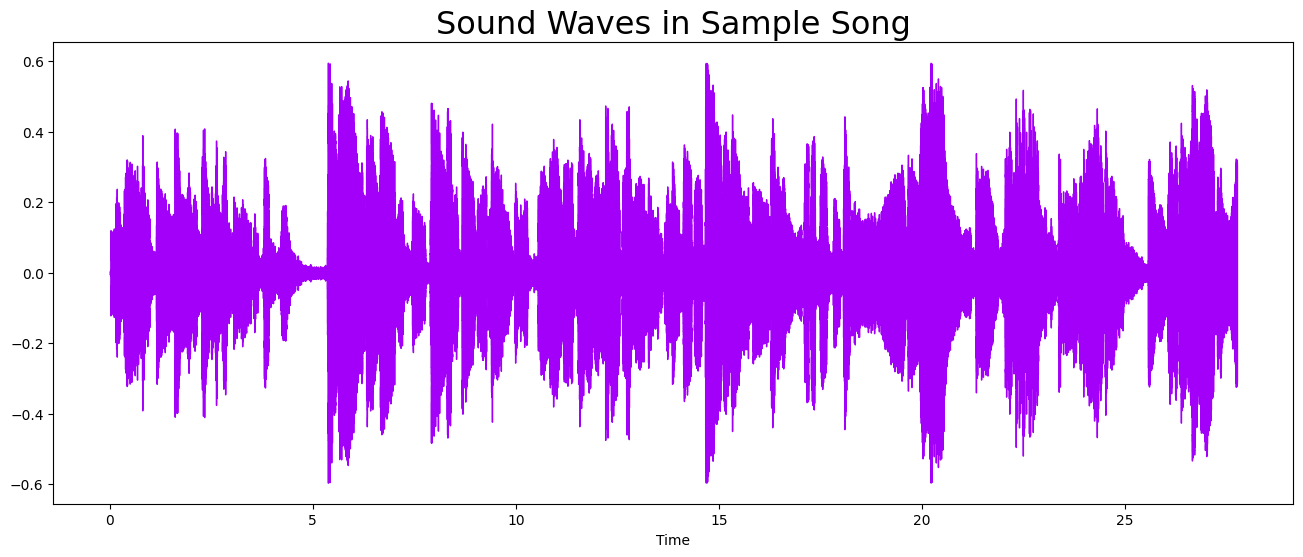

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=y, sr=SAMPLE_RATE, color="#A300F9")
plt.title("Sound Waves in Sample Song", fontsize = 23);

### Spectrogram

A spectrogram is a visual representation of the spectrum of frequencies in a sound signal as it varies over time. With the *specshow()* function, a two-dimensional plot where the horizontal axis represents time, the vertical axis represents frequency, and the intensity or color represents the amplitude of each frequency component can be displayed.

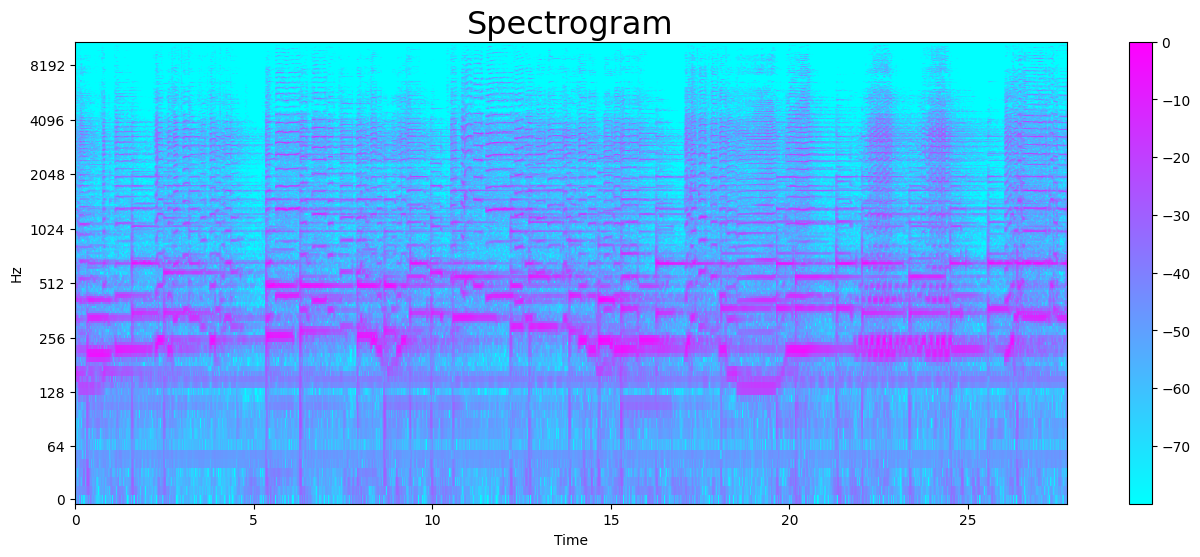

In [ ]:
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))

DB = librosa.amplitude_to_db(D, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.title("Spectrogram", fontsize=23)
plt.colorbar();

### Mel spectrogram

A Mel spectrogram is a type of spectrogram where the frequency scale is warped according to the Mel scale, which is a perceptual scale of pitch that more closely matches the way the human ear perceives sound.

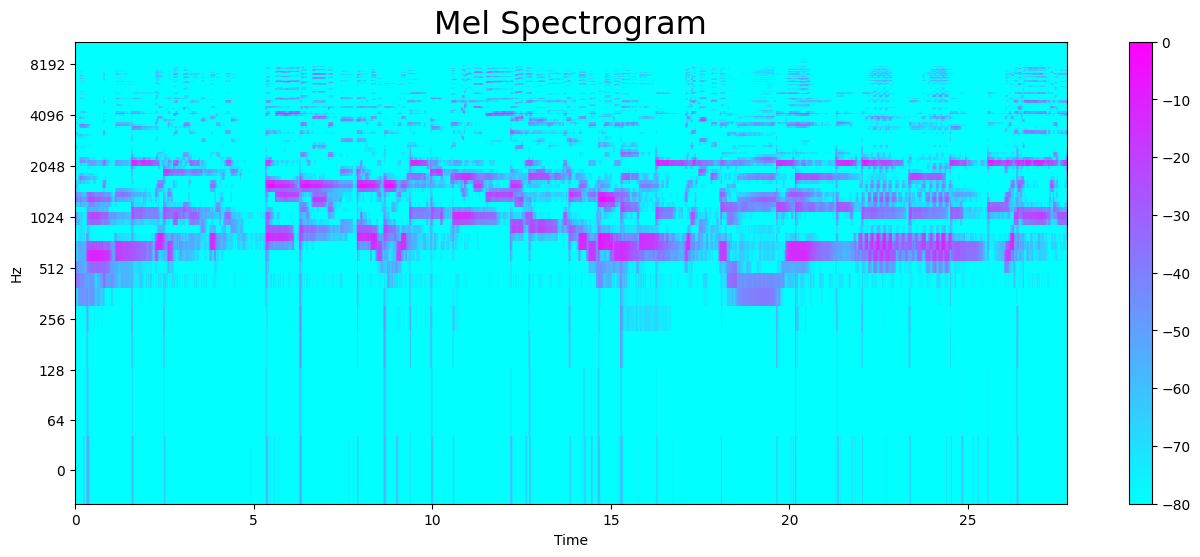

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram", fontsize=23)
plt.show()

### Tempo (BPM)

Tempo, measured in beats per minute (BPM), refers to the speed or pace of a piece of music.

In [ ]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
tempo

array([83.35433468])

### Spectral centroids

The spectral centroid is a measure of the "brightness" of a sound. It represents the weighted average of the frequencies present in the sound, with the weights being the amplitudes of the corresponding frequency components.

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

print('First 10 centroids:', spectral_centroids[:10], '\n')
print('Shape of Spectral Centroids feature:', spectral_centroids.shape, '\n')

First 10 centroids: [1428.77109542 1357.86547146 1327.74679623 1398.85553049 1404.67862065
 1596.88620068 1858.00118363 1957.29959271 1954.91890931 1834.29786693] 

Shape of Spectral Centroids feature: (1196,) 



### Spectral bandwidth

Spectral bandwidth is a measure of the width of the signal's frequency spectrum, indicating the range of frequencies present in the signal. The function computes the second central moment (variance) of the spectrum's magnitude, which quantifies the spread of the spectral energy around its mean frequency

In [ ]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

### Spectral rolloff

Spectral rolloff is a measure of the frequency below which a certain percentage (set by default at 85%) of the total spectral energy is contained.

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
spectral_rolloff[:10]

array([[2971.58203125, 2950.04882812, 3057.71484375, ..., 3283.81347656,
        3294.58007812, 3305.34667969]])

### Chroma frequencies (chromagram)

A chromagram is a representation of the musical content in an audio signal. It is obtained by using the Short-Time Fourier Transform (STFT) to compute the spectral content of the audio, and then mapping the resulting frequencies to a set of 12 pitch classes, which correspond to the notes in the Western chromatic scale (A, A#, B, C, C#, D, D#, E, F, F#, G, G#).

The Chromagram is a matrix where each row corresponds to one of the 12 pitch classes, and each column corresponds to a time frame. The values in the matrix represent the intensity or presence of each pitch class in each time frame.

Chromogram shape: (12, 1196)


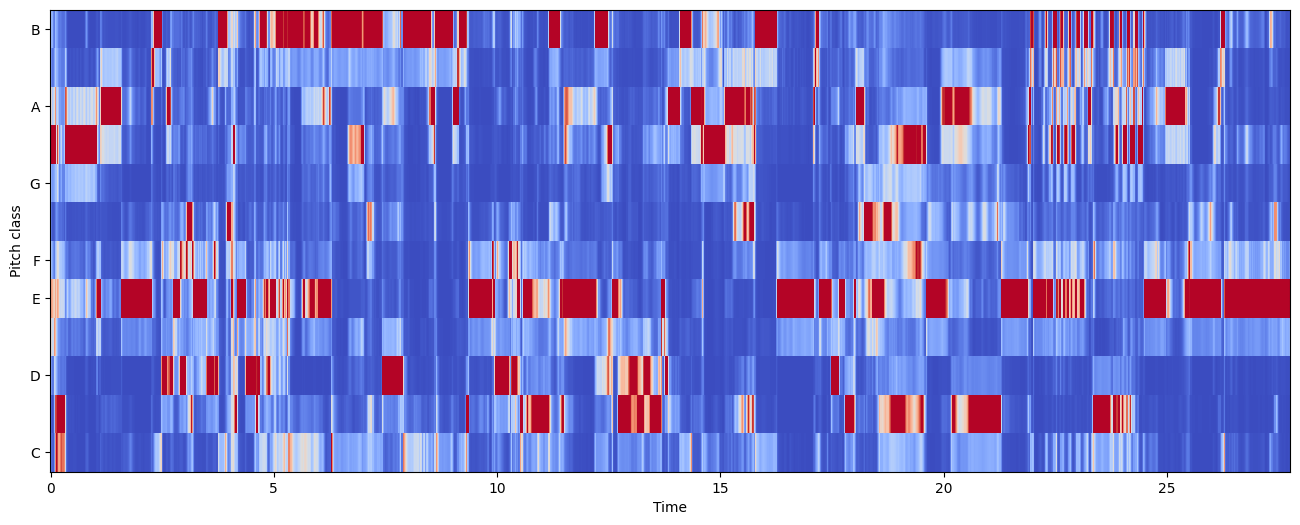

In [ ]:
hop_length = 128

chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm');

### Zero-crossing rate

The zero-crossing rate is a measure of the number of times an audio signal's amplitude crosses zero in a given time frame. It's used to detect changes in the signal, such as onsets and offsets of musical notes or speech sounds.

In [ ]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
zero_crossing_rate[:, :10]

array([[0.04882812, 0.0625    , 0.07373047, 0.04638672, 0.0546875 ,
        0.06835938, 0.08251953, 0.09912109, 0.1015625 , 0.09716797]])

### Root-mean-square (RMS)

Computes the root-mean-square (RMS) value for each frame

In [ ]:
rms = librosa.feature.rms(y=y)
rms.shape

(1, 1196)

### Polynomial features

Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram

In [ ]:
poly_features = librosa.feature.poly_features(y=y, sr=sr)

### Tonal centroid features

Compute the tonal centroid features, also knwon as *tonnetz*.

In [ ]:
tonnetz = librosa.feature.tonnetz(y=y)

## Feature extraction process

### Image features

Among the experiments carried out, we also wanted to create a CNN that can be trained on images. In this case, being in a musical domain, the image used to train the model is based on the musical spectrogram of each song in the dataset. Below are the steps:

Functions useful for this purpose are defined and a brief description of their behavior is provided:


* ***extract_features(file_path) :*** This function takes the path of an audio file as input and extracts its mel spectrogram using the librosa library. Loads the first 30 seconds of the file, calculates the mel spectrogram with 128 mel bands and converts the power values ​​to decibels. If an error occurs during feature extraction, an error message is printed and the function returns None.
* ***save_spectogram_image(mel_spec, file_name) :*** This function saves an image of a mel spectrogram. It takes as input the spectrogram and the name of the file in which to save the image. It uses matplotlib and librosa.display to display the mel spectrogram and saves it as a PNG image with an 'inferno' color map. The axes are hidden to improve image clarity.
* ***preprocess_dataset_spectrograms(dataset_path) :*** This function preprocesses a dataset of audio files organized by genre. It reads music genre folders, extracts .wav files, and for each file, extracts the mel spectrogram and saves it as a PNG image. Saved image paths and genre labels are added to a list. Finally, the lists are converted into a pandas DataFrame containing the image paths and corresponding labels.
* ***align_images(mel_spec_db): :*** Then we wanted to align the images on the 3 RGB color channels through the use of specshow(), a function from the librosa library, in such a way as to increase the dataset on which the model is trained; we expect the accuracy to increase with a dataset augmented this way.

In [ ]:
import numpy as np

In [ ]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        # Estrarre il mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Align the spectrogram image
        aligned_image = align_images(mel_spec_db)
        return aligned_image
    except Exception as e:
        print(f"Errore durante l'estrazione delle caratteristiche da {file_path}: {e}")
        return None

def save_spectrogram_image(mel_spec, file_name):
    plt.figure(figsize=(2, 2))
    librosa.display.specshow(mel_spec, sr=22050, cmap='inferno')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()

def preprocess_dataset_spectrograms(dataset_path):
    genres = os.listdir(dataset_path)
    data = []
    labels = []
    output_dir = OUTPUT_DIR_FOR_SPECTOGRAMS
    os.makedirs(output_dir, exist_ok=True)

    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(genre_path, file)
                    mel_spec = extract_features(file_path)
                    if mel_spec is not None:
                        # Salva l'immagine nella directory di lavoro
                        img_file_name = os.path.basename(file_path).replace('.wav', '.png')
                        img_file_path = os.path.join(output_dir, genre + '_' + img_file_name)
                        save_spectrogram_image(mel_spec, img_file_path)
                        data.append(img_file_path)
                        labels.append(genre)

    return pd.DataFrame({'path': data, 'label': labels})

def align_images(mel_spec_db):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mel_spec_db, sr=22050, ax=ax, cmap='inferno')
    fig.canvas.draw()
    aligned_image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return aligned_image

The method below is used to generate spectrograms from audio files.

In [ ]:
def generate_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Convert to RGB
    fig = plt.figure(figsize=(1.28, 1.28), dpi=100)
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(S_DB, aspect='auto', origin='lower')
    fig.canvas.draw()

    # Convert plot to numpy array
    spectrogram = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    spectrogram = spectrogram.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return spectrogram

This method instead, is a generator function to yield spectrograms and labels.

In [ ]:
def data_generator(audio_dir):
    genres = os.listdir(audio_dir)
    genre_to_label = {genre: idx for idx, genre in enumerate(genres)}

    for genre in genres:
        genre_dir = os.path.join(audio_dir, genre)
        for file in os.listdir(genre_dir):
            if file.endswith('.mp3'):
                audio_path = os.path.join(genre_dir, file)
                spectrogram = generate_spectrogram(audio_path)
                label = genre_to_label[genre]
                yield spectrogram, label

The data necessary to perform both feature extraction and then afterwards the necessary training for the models on these very features, have been uploaded onto the Google drive platform, in order to then use a package called gdown to download these files.

What we did initially, was obviously to extract all of the almost 12K features manually, using the folder we already actually downloaded, the one we got by using gdown before the feature explanation.

But, because extracting the features of all almost 12K songs takes a long while (around an hour with powerful hardware), we also decided to include a downloadable zip file, with the code below, containing a .npy file (a numpy file), which already contains all the extracted features, and has to just be loaded in memory.

In [ ]:
from IPython.display import clear_output
!gdown 1b3aDSdAjKpbyl0cxD-qP-7qtL7s7fCIn
!unzip songs1710.zip

!rm songs1710.zip
clear_output()

### Rythmic and spectral features

We first load the dataset into memory by either extracting it manually using the cell block below, or using the already extracted features from the .npy file in order to save time.

We recommend to take a look at the save_features method below, but not use it as it will take a lot of time to extract all almost 12K songs present in the songs1710 folder, therefore we suggest to use the cells after which will load the songs1710.npy numpy file which will contain the features already extracted.

Duration, indicates the length of the song to extract, and since each song is 30 seconds, we write 30.

In [ ]:
DURATION = 30

In [ ]:
def save_features(dataset_path, batch_size=100):
    # Initialize the combined features and labels array
    data = []
    labels = []
    # Create a mapping of labels to numeric indices
    label_to_index = {}
    # Initialize counters
    num_valid = 0
    num_invalid = 0
    counter = 0

    # Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            # Save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            # Create a mapping of labels to numeric indices
            if semantic_label not in label_to_index:
                label_to_index[semantic_label] = len(label_to_index)

            # Process files for specific genre in batches
            for batch_start in range(0, len(filenames), batch_size):
                batch_end = min(batch_start + batch_size, len(filenames))
                batch_files = filenames[batch_start:batch_end]
                for f in batch_files:
                    # Load audio file
                    file_path = os.path.join(dirpath, f)
                    try:
                        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    except FileNotFoundError:
                        print(f"File not found: {file_path}")
                        continue
                    except sf.LibsndfileError:
                        print(f"Error loading file: {file_path}")
                        continue

                    # SEGMENTATION DURING FEATURE EXTRACTION NOT USED CURRENTLY SO SET TO 1
                    num_segments = 1
                    segment_size = int(len(y) / num_segments)
                    for j in range(num_segments):
                        start_time = time.time()  # start the timer
                        start = j * segment_size
                        end = (j + 1) * segment_size
                        if j == num_segments - 1:  # For the last segment, include the remaining part of the audio
                            end = len(y)
                        segment = y[start:end]

                        # Extract features
                        mfcc = librosa.feature.mfcc(y=segment, sr=sr)
                        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
                        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
                        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
                        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
                        mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=16)
                        tempo, beats = librosa.beat.beat_track(y=segment, sr=sr)
                        rms = librosa.feature.rms(y=segment)
                        spectral_rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
                        poly_features = librosa.feature.poly_features(y=segment, sr=sr)
                        tonnetz = librosa.feature.tonnetz(y=segment)

                        # Repeat the scalar values n times
                        n = zero_crossing_rate.shape[1]  # Number of frames
                        tempo_reshaped = np.repeat(tempo, n).reshape(1, -1)
                        beats_reshaped = np.tile(np.expand_dims(beats, axis=1), (1, mfcc.shape[1]))
                        beats_trimmed = beats_reshaped[:9, :]


                        print(f"Features shape for stacking: ")
                        print(f"Mfcc {np.array(mfcc).shape}")
                        print(f"Spectral Centroid {np.array(spectral_centroid).shape}")
                        print(f"Spectral Bandwidth {np.array(spectral_bandwidth).shape}")
                        print(f"Zero Crossing Rate{np.array(zero_crossing_rate).shape}")
                        print(f"Chroma {np.array(chroma).shape}")
                        print(f"Mel {np.array(mel).shape}")
                        print(f"Tempo {np.array(tempo_reshaped).shape}")
                        print(f"RMS {np.array(rms).shape}")
                        print(f"Spectral Rolloff {np.array(spectral_rolloff).shape}")
                        print(f"Poly Features {np.array(poly_features).shape}")
                        print(f"Tonnetz {np.array(tonnetz).shape}")


                        # Stack the features
                        features = np.vstack([mfcc, spectral_centroid, spectral_bandwidth, zero_crossing_rate, chroma, mel,
                                              tempo_reshaped, rms, spectral_rolloff, poly_features, tonnetz])
                        features = np.transpose(features, (1, 0))
                        print("features:", features.shape)

                        # Trim + add the features and label to the data list
                        size_dim_zero = 1150
                        if features.shape[0] > size_dim_zero:
                            data.append(features[:size_dim_zero, :])
                            print("appending:" + str(features[:size_dim_zero, :].shape))
                            labels.append(i-1)
                            num_valid += 1
                            print(f"Processing: {file_path}")
                        elif features.shape[0] == size_dim_zero:
                            data.append(features)
                            print("appending:" + str(features.shape))
                            labels.append(i-1)
                            num_valid += 1
                            print(f"Processing: {file_path}")
                        else:
                            num_invalid += 1
                            print(f"Invalid shape: {features.shape} for file: {file_path}")
                        counter = counter + 1
                        print("Counter:", counter)
                        end_time = time.time()  # end the timer
                        processing_time = end_time - start_time  # calculate the processing time
                        print(f"Time required to process segment {j+1}: {processing_time} seconds")
                        print("\n")

    print(f"Number of files processed successfully: {num_valid}")
    print(f"Number of files with invalid shapes: {num_invalid}")

    # Convert the data list to a NumPy array
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [ ]:
data, labels = save_features("./songs1710")
clear_output()

In [ ]:
data.shape, labels.shape

### Loading pre-extracted features

As stated before, and assuming you already ran the appropriate gdown cell, the code below will load the features in memory from the .npy file.

In [ ]:
with open('songs1710.npy', 'rb') as f:
    data = np.load(f)
    labels = np.load(f)

data.shape, labels.shape

((11205, 1150, 62), (11205,))

# 3. Data pre-processing and dataset creation

In this section several functions that will be used to compose the pre-processing pipeline are defined

## Outlier handling

In order to remove the outliers from the dataset, we will first import the zscore function to calculate the zscore of each feature, then we will cut out the outliers, replace the outliers with the mean value of each feature and then place these values back in the dataset.

In [ ]:
from scipy.stats import zscore

Two variables can be noticed in the cell block below:
*   Slices, which is an array containing the slicing necessary to do onto to data feature array that has been extracted, this is necessary because of the fact that during the features extraction, the features have been then concatenated, and we need to know which dimension corresponds with which. We can see in our case that they are hardocoded, that's because when extracting the features, we are concatenating them, therefore in order to operate on the concatenated row, we need to know how "long" the features are, and we did this manually;
*   feature_names, it's once again a simple array containing the names of the extracted features which will be used again in the cell below to identify each slicing done.

In [ ]:
slices = [20, 1, 1, 1, 12, 16, 1, 1, 1, 2, 6]
feature_names = ['mfcc', 'centroid', 'bandwidth', 'zero_crossing', 'chroma', 'mel', 'tempo', 'rms', 'rolloff', 'poly', 'tonnetz']

def transpose_feature(feature):
    if feature.ndim == 1:
        return np.expand_dims(feature, axis=1).T
    return feature.T

def slice_features(song, slices):
    features = {}
    start_index = 0

    for i, length in enumerate(slices):
        end_index = start_index + length if length > 1 else start_index + 1
        feature_name = f'feature_{i}'  # You can name your features more appropriately if needed
        features[feature_name] = transpose_feature(song[:, start_index:end_index])
        start_index = end_index

    return features

def get_features(song):
    features = slice_features(song, slices)

    features = {name: features[f'feature_{i}'] for i, name in enumerate(feature_names)}
    return features

def compute_z_scores(features):
    return {key: zscore(value, axis=1) for key, value in features.items()}

def identify_outliers(z_scores, threshold=3):
    return {key: np.abs(value) > threshold for key, value in z_scores.items()}

def delete_outliers(features, outliers):
    return {key: value[:, ~np.any(outliers[key], axis=0)] for key, value in features.items()}

def determine_target_length(features):
    return max(value.shape[1] for value in features.values())

def pad_features(feature, target_length):
    """Pad or trim the feature to the target length using the median of the array for padding."""
    median_value = np.median(feature)
    if feature.shape[1] < target_length:
        pad_width = target_length - feature.shape[1]
        feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant', constant_values=median_value)
    else:
        feature = feature[:, :target_length]
    return feature

def pad_all_features(features, target_length):
    return {key: pad_features(value, target_length) for key, value in features.items()}

def replace_feature_data(song, feature_data, start_index, end_index):
    if feature_data.ndim > 1:
        processed_data = np.transpose(feature_data)
    else:
        processed_data = feature_data.flatten()

    song[:, start_index:end_index] = processed_data

def replace_features(song, features, slices):
    start_index = 0
    for i, length in enumerate(slices):
        end_index = start_index + length if length > 1 else start_index + 1
        replace_feature_data(song, features[feature_names[i]], start_index, end_index)
        start_index = end_index

def clip_song(song):
    features = get_features(song)
    z_scores = compute_z_scores(features)
    outliers = identify_outliers(z_scores)
    features = delete_outliers(features, outliers)
    target_length = determine_target_length(features)
    features = pad_all_features(features, target_length)
    replace_features(song, features, slices)

def handle_outliers(features):
  for song in features:
    clip_song(song)

 ## Data splitting

This function is used to manually create the training and test sets in the form of Numpy arrays:

In [ ]:
def split_data(data, labels, train_size=0.75):
    # Get unique labels and their indices
    unique_labels, indices = np.unique(labels, return_inverse=True)

    # Get a mask to sort the indices by label
    mask = np.argsort(indices)

    # Initialize lists to store train and test data and labels
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    # Split data and labels into training and test sets
    start = 0
    for label in unique_labels:
        label_mask = indices == label
        label_indices = mask[label_mask]
        num_examples = len(label_indices)
        train_size_for_label = int(train_size * num_examples)

        train_data.append(data[label_indices[:train_size_for_label]])
        train_labels.append(labels[label_indices[:train_size_for_label]])
        test_data.append(data[label_indices[train_size_for_label:]])
        test_labels.append(labels[label_indices[train_size_for_label:]])

    # Concatenate the lists into numpy arrays
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels)

    return train_data, train_labels, test_data, test_labels

## Data scaling

This function is used to perform standard scaling on the training set and test set. The scaling is performed after splitting the data into two sets to ensure that the scaling parameters (mean and standard deviation) are learned from the training data only, and not from the test data. This is important because the goal of a machine learning model is to generalize well to new, unseen data. If the scaling parameters were learned from the test data, this would leak information about the test data to the model, which could result in overfitting and poor performance on unseen data.

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize_data(train_data, test_data):
    train_shape = train_data.shape
    test_shape = test_data.shape

    train_data = train_data.reshape(-1, train_shape[-1])
    test_data = test_data.reshape(-1, test_shape[-1])

    scaler = StandardScaler()
    scaler.fit(train_data)

    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    if len(train_shape) > 2:
        train_data = train_data.reshape(train_shape)

    if len(test_shape) > 2:
        test_data = test_data.reshape(test_shape)

    return train_data, test_data


## Data segmentation

This function is used to segment the input data into the desired amount of segments and to repeat the corresponding labels.

In [ ]:
def segment_data(data, labels, num_segments):
    print(f"Shape of training data before segmentation: {data.shape}")
    print(f"Shape of labels: {labels.shape}")

    shape = data.shape
    print(shape)
    segmented_data = np.reshape(np.transpose(np.reshape(data, (shape[0], num_segments, int(shape[1]/num_segments), shape[2])), (0, 2, 1, 3)), (shape[0] * num_segments, int(shape[1]/num_segments), shape[2]))

    # Repeat labels
    segmented_labels = np.repeat(labels, num_segments)

    print(f"Shape of training data after segmentation: {segmented_data.shape}")
    print(f"Shape of labels: {segmented_data.shape}")

    return segmented_data, segmented_labels


# 4. Model creation

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import keras_nlp.layers as nlp_layers
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from tensorflow.keras import Model

## Convolutional Neural Network

Convolutional neural networks are mostly used to process images, but their architecture makes them suitable for all kinds of array-like input shapes, such as out input of shape (timesteps, feature_count). The defined architecture uses multiple blocks composed of a convolutional layer to extract features, a batch normalization layer to make the net more stable in training and a max pooling layer to reduce dimensionality. After three of these described blocks there's a final part with a dense layer with ReLU activation and a dropout layer. Finally we have dense layer with num_classes neurons and a softmax activation function as this is a classification problem.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn_model(timesteps, feature_count, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(timesteps, feature_count, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

This method below here, also builds the model used in the spectrograms training.

In [ ]:
def build_cnn_spectrogram_model(img_shape1, img_shape2, numclasses):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_shape1, img_shape2, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(numclasses, activation='softmax'))
  return model

## Recurrent neural network
In this section a deep RNN will be created.

![alt text](https://biolab.csr.unibo.it/ferrara/Courses/DL/Tutorials/RNN/DeepRNN.png)

**Model definition**
The following function creates a deep DNN model given:
- the number of timesteps in each input sequence (*timesteps*);
- the number of features in each timestep (*feature_count*);
- the number of units for each RNN layer (*unit_count_per_rnn_layer*).

The model returns a single target value given an entire sequence as input (*many-to-one*).

<u>Note that, the number of timesteps in each input sequence (*timesteps*) is set in advance only because it improves performance during training by creating tensors of fixed shapes. A *None* value can be used to admit variable-length input sequences.</u>

In [ ]:
def build_deep_rnn(timesteps, feature_count, num_classes, unit_count_per_rnn_layer=[128, 128]):
    model = Sequential()
    model.add(layers.Input(shape=(timesteps, feature_count)))

    for i in range(len(unit_count_per_rnn_layer)):
        model.add(layers.SimpleRNN(unit_count_per_rnn_layer[i], return_sequences=True if i < (len(unit_count_per_rnn_layer) - 1) else False))

    if unit_count_per_rnn_layer[-1] > 1:
        model.add(layers.Dense(num_classes, activation='softmax'))

    return model

## Transformer

Transformers have been a breakthrough in the field of natural language processing and have recently been applied to other sequence domains, such as music. In classification cases such as this one, only the encoder part of the transformer is used, because the task here is to map an input sequence to a single output label, rather than generating a sequence of outputs as in tasks such as machine translation or music generation.

The encoder part of the transformer is responsible for processing the input sequence and extracting a set of contextualized representations, or *keys*, *values*, and *queries*, that capture the relationships between the elements of the sequence. These representations are then used to compute a weighted sum of the values for each element, which is interpreted as a context-dependent representation of the element.

In a classification task, the final context-dependent representation of the entire input sequence is used as the input to a dense layer with a softmax activation function, which maps the representation to a probability distribution over the possible output labels.

The decoder part of the transformer, which is responsible for generating a sequence of outputs, is not needed in a classification task because the output is a single label rather than a sequence.

The used architecture is as follows:
1. Input layer of size (time_steps, feature_count).
2. Positional encoding as the position in the sequence is relevant for music.
3. Four transformer encoder layers. Each encoder layer consists of a multi-head self-attention mechanism, followed by a dense layer with a ReLU activation function. The output of each encoder layer is added to the input and passed through a layer normalization and dropout layer before being passed to the next encoder layer.
4. Global average pooling to reduce the dimensionality of the data and extract a single feature vector for the entire sequence.
5. Dense layer with 512 neurons and ReLU activations.
6. Output layers with a neuron for each class (music genre) and softmax activation.


In [ ]:
def build_transformer_classifier(time_steps, feature_count, num_classes):
    input = layers.Input(shape=(time_steps, feature_count))
    pos_enc = nlp_layers.SinePositionEncoding()(input)
    add = layers.Add()([input, pos_enc])

    transf_enc = add
    for _ in range(4):
        attention_output = layers.MultiHeadAttention(key_dim=feature_count, num_heads=4)(transf_enc, transf_enc)
        attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
        attention_output = layers.Dropout(0.1)(attention_output)
        transf_enc = layers.Add()([transf_enc, attention_output])
        ffn_output = layers.Dense(feature_count, activation='relu')(transf_enc)
        transf_enc = layers.Add()([transf_enc, ffn_output])

    gl_avg_pool = layers.GlobalAveragePooling1D()(transf_enc)
    dense = layers.Dense(512, activation='relu')(gl_avg_pool)
    drop = layers.Dropout(rate=0.15)(dense)
    out = layers.Dense(num_classes, activation='softmax')(drop)

    model = Model(inputs=input, outputs=out)

    return model

# 5. Experiments

Utility functions:

In [ ]:
from sklearn.metrics import confusion_matrix

The following are the preprocessing pipelines, a standard one and one that segments the songs. The input are the *data* and *labels* Numpy arrays obtained earlier, along with the desired batch size. For the segmented variant, the number of desired semgents for each song also has to be specified.

In [ ]:
def preprocess_dataset(data, labels, batch_size):
    data_clipped = data
    handle_outliers(data_clipped)
    train_data, train_labels, test_data, test_labels = split_data(data_clipped, labels)
    train_data_scaled, test_data_scaled = standardize_data(train_data, test_data)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data_scaled, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled, test_labels))
    test_dataset = test_dataset.shuffle(buffer_size=10000).batch(batch_size)

    return train_dataset, test_dataset

def preprocess_dataset_segmented(data, labels, batch_size, num_segments):
    data_clipped = data
    handle_outliers(data_clipped)
    train_data, train_labels, test_data, test_labels = split_data(data_clipped, labels)
    train_data_scaled, test_data_scaled = standardize_data(train_data, test_data)
    train_data_segmented, train_labels = segment_data(train_data_scaled, train_labels, num_segments)
    test_data_segmented, test_labels = segment_data(test_data_scaled, test_labels, num_segments)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data_segmented, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data_segmented, test_labels))
    test_dataset = test_dataset.shuffle(buffer_size=10000).batch(batch_size)

    return train_dataset, test_dataset

In [ ]:
def evaluate_model(model_path, test_dataset):
    # Load the best model
    best_model = tf.keras.models.load_model(model_path)

    test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)

    true_labels = []
    predicted_labels = []

    # Iterate over the test data in batches
    for batch_data, batch_labels in test_dataset:
        batch_predictions = best_model.predict(batch_data)
        batch_predictions = np.argmax(batch_predictions, axis=1)

        true_labels.extend(batch_labels.numpy())
        predicted_labels.extend(batch_predictions)

    cm = confusion_matrix(true_labels, predicted_labels)

    results = {
        'confusion_matrix': cm,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    }

    return results

In [ ]:
def evaluate_model_spectrograms(model_path, test_dataset):
    # Load the best model
    best_model = tf.keras.models.load_model(model_path)

    test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)

    true_labels = []
    predicted_labels = []

    # Iterate over the test data in batches
    for batch_data, batch_labels in test_dataset:
        batch_predictions = best_model.predict(batch_data, verbose=0)
        batch_predictions = np.argmax(batch_predictions, axis=1)

        true_labels.extend(batch_labels)
        predicted_labels.extend(batch_predictions)

    cm = confusion_matrix(true_labels, predicted_labels)

    results = {
        'confusion_matrix': cm,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    }

    return results

## Input length (song duration)

In this experiment, the goal is to understand how input duration affects performance. Performance is expected to decrease as the duration of the input, i.e., the dimensionality of the examples, decreases. The objective is to understand whether this impact of dimensionality on performance exists, and what is its rate. In a real use case of such a model, it would be ideal to use the right tradeoff between performance and dimensionality of the input, in order to minimize the training cost and speed in inference while still achieving the desired performance.

Three trials are conducted: full duration (30 seconds), half duration (15 seconds) and one-sixth of the duration (5 seconds). The three trials are performed on all three models in order to obtain information about the performance of the models and their behavior as the input size changes.

To create the datasets for the experiments, Python slicing is simply used on the second dimension (that of time frames) while keeping the central portion of the data, i.e. the song, as we empirically deem the central portion the most semantically relevant.

In [ ]:
start_idx_half = data.shape[1] // 4  # Start at 1/4th of the columns
end_idx_half = data.shape[1] * 3 // 4  # End at 3/4th of the columns
data_half_length = data[:, start_idx_half:end_idx_half, :]

start_idx_sixth = data.shape[1] * 5 // 12  # Start at 5/12th of the columns
end_idx_sixth = data.shape[1] * 7 // 12  # End at 7/12th of the columns
data_sixth_length = data[:, start_idx_sixth:end_idx_sixth, :]

In [ ]:
train_dataset_full_length, test_dataset_full_length = preprocess_dataset(data, labels, 64)
train_dataset_half_length, test_dataset_half_length = preprocess_dataset(data_half_length, labels, 64)
train_dataset_sixth_length, test_dataset_sixth_length = preprocess_dataset(data_sixth_length, labels, 64)

In the cell below, the idea is add or remove comments on the models that we need to test, e.g. if we wanted to test the transformer model we would need to add a comment to every line except 1, 5 and 9.

In [ ]:
model_full_length = build_transformer_classifier(train_dataset_full_length.element_spec[0].shape[1], 62, 7)
# model_full_length = build_deep_rnn(train_dataset_full_length.element_spec[0].shape[1], 62, 7)
# model_full_length = build_cnn_model(train_dataset_full_length.element_spec[0].shape[1], 62, 7)

model_half_length = build_transformer_classifier(train_dataset_half_length.element_spec[0].shape[1], 62, 7)
# model_half_length = build_deep_rnn(train_dataset_half_length.element_spec[0].shape[1], 62, 7)
# model_half_length = build_cnn_model(train_dataset_half_length.element_spec[0].shape[1], 62, 7)

model_sixth_length = build_transformer_classifier(train_dataset_sixth_length.element_spec[0].shape[1], 62, 7)
# model_sixth_length = build_deep_rnn(train_dataset_sixth_length.element_spec[0].shape[1], 62, 7)
# model_sixth_length = build_cnn_model(train_dataset_sixth_length.element_spec[0].shape[1], 62, 7)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# We compile the full length model
optimizer = Adam(learning_rate=0.00001)

model_full_length.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# And here we train the model
history = model_full_length.fit(train_dataset_full_length, epochs=100, validation_data=test_dataset_full_length, callbacks=[early_stopping, checkpoint])

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1593 - loss: 9.0589
Epoch 1: val_accuracy improved from -inf to 0.14520, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.1592 - loss: 9.0199 - val_accuracy: 0.1452 - val_loss: 133.9728
Epoch 2/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1495 - loss: 1.9469
Epoch 2: val_accuracy improved from 0.14520 to 0.14806, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.1495 - loss: 1.9469 - val_accuracy: 0.1481 - val_loss: 36.0268
Epoch 3/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1487 - loss: 1.9459
Epoch 3: val_accuracy improved from 0.14806 to 0.19479, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.1487 - loss: 1.9459 - val_accuracy: 0.1948 - val_loss: 2.8833
Epoch 4/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1338 - loss: 1.9510
Epoch 4: val_accuracy did 

In [ ]:
# With this line of code we evaluate the model

evaluate_model(best_model_path, test_dataset_full_length)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━

{'confusion_matrix': array([[293,  23,  33,  31,   2,   0,  29],
        [188,  12,  66,  88,   2,   1,  34],
        [263,   8,  46,  31,   4,   1,  33],
        [177,  14,  57, 125,   0,   0,  31],
        [191,  13,  71,  71,   0,   0,  60],
        [177,   7, 102,  67,   1,   1,  45],
        [140,   8, 125,  53,   2,   8,  69]]),
 'test_accuracy': 0.1947913020849228,
 'test_loss': 2.8832738399505615}

In [ ]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# We compile the full length model
optimizer = Adam(learning_rate=0.00001)

# We compile the half length model
model_half_length.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_half_length.fit(train_dataset_half_length, epochs=100, validation_data=test_dataset_half_length, callbacks=[early_stopping, checkpoint])

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2190 - loss: 2.3880
Epoch 1: val_accuracy improved from -inf to 0.19693, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.2192 - loss: 2.3853 - val_accuracy: 0.1969 - val_loss: 2.0461
Epoch 2/100
129/132 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3057 - loss: 1.7724
Epoch 2: val_accuracy improved from 0.19693 to 0.27863, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3059 - loss: 1.7718 - val_accuracy: 0.2786 - val_loss: 1.9191
Epoch 3/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3462 - loss: 1.6845
Epoch 3: val_accuracy improved from 0.27863 to 0.32572, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3463 - loss: 1.6845 - val_accuracy: 0.3257 - val_loss: 1.7444
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3753 - loss: 1.6276
Epoch 4: val_accuracy improve

In [ ]:
evaluate_model(best_model_path, test_dataset_half_length)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━

{'confusion_matrix': array([[262,  19,  34,   8,  59,  10,  19],
        [ 41, 119,  37,  63,  48,  36,  47],
        [ 57,  18, 130,  12,  60,  30,  79],
        [  5,  69,  18, 232,  28,  24,  28],
        [ 80,  26,  38,  21, 181,  18,  42],
        [ 27,  41,  66,  45,  52,  71,  98],
        [ 24,  31,  43,  19,  30,  50, 208]]),
 'test_accuracy': 0.4291830062866211,
 'test_loss': 1.6336402893066406}

In [ ]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# We compile the full length model
optimizer = Adam(learning_rate=0.00001)

# We compile the sixth length model
model_sixth_length.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_sixth_length.fit(train_dataset_sixth_length, epochs=100, validation_data=test_dataset_sixth_length, callbacks=[early_stopping, checkpoint])

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1920 - loss: 3.1314
Epoch 1: val_accuracy improved from -inf to 0.18623, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.1922 - loss: 3.1267 - val_accuracy: 0.1862 - val_loss: 2.1241
Epoch 2/100
129/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2557 - loss: 1.9046
Epoch 2: val_accuracy improved from 0.18623 to 0.22833, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2562 - loss: 1.9037 - val_accuracy: 0.2283 - val_loss: 2.0269
Epoch 3/100
129/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3014 - loss: 1.7909
Epoch 3: val_accuracy improved from 0.22833 to 0.29147, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3016 - loss: 1.7906 - val_accuracy: 0.2915 - val_loss: 1.8253
Epoch 4/100
129/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3142 - loss: 1.7358
Epoch 4: val_accuracy improved f

In [ ]:
evaluate_model(best_model_path, test_dataset_sixth_length)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━

{'confusion_matrix': array([[275,  26,  27,   5,  45,  20,  13],
        [ 52, 124,  34,  73,  31,  42,  35],
        [ 62,  16, 123,  19,  59,  53,  54],
        [ 10,  61,  14, 230,  29,  33,  27],
        [ 98,  39,  42,  32, 131,  34,  30],
        [ 31,  47,  64,  38,  50,  83,  87],
        [ 19,  37,  46,  11,  35,  79, 178]]),
 'test_accuracy': 0.4081341326236725,
 'test_loss': 1.6481750011444092}

These cell blocks below will delete unwanted variables that we don't need going forward, to free up some memory.

In [ ]:
del test_dataset_full_length, test_dataset_half_length, test_dataset_sixth_length

In [ ]:
del train_dataset_full_length, train_dataset_half_length, train_dataset_sixth_length

In [ ]:
del model_full_length, model_half_length, model_sixth_length

In [ ]:
del start_idx_half, start_idx_sixth, end_idx_half, end_idx_sixth

In [ ]:
del data_half_length, data_sixth_length

## Data segmentation

In this experiment, the goal is to see if model performance can be improved by data augmentation, segmenting the input data into multiple parts in order to increase the number of examples.
Two segmentation tests are conducted, to be compared with the baseline of not segmenting the examples: five segments per song and ten segments per song.

When segmenting songs, it is important that there is no leaking between training set and test set, in other words, it must be ensured that all segments of a single song remain in their set. This is important because otherwise the performance on the test set cannot not be considered reliable. Segmentation taking this constraint into account is carried out by the appropriate function defined among the pre-processing functions in Section 3.

In [ ]:
train_dataset_five_segments, test_dataset_five_segments = preprocess_dataset_segmented(data, labels, 64, 5)
train_dataset_ten_segments, test_dataset_ten_segments = preprocess_dataset_segmented(data, labels, 64, 10)

Shape of training data before segmentation: (8402, 1150, 62)
Shape of labels: (8402,)
(8402, 1150, 62)
Shape of training data after segmentation: (42010, 230, 62)
Shape of labels: (42010, 230, 62)
Shape of training data before segmentation: (2803, 1150, 62)
Shape of labels: (2803,)
(2803, 1150, 62)
Shape of training data after segmentation: (14015, 230, 62)
Shape of labels: (14015, 230, 62)
Shape of training data before segmentation: (8402, 1150, 62)
Shape of labels: (8402,)
(8402, 1150, 62)
Shape of training data after segmentation: (84020, 115, 62)
Shape of labels: (84020, 115, 62)
Shape of training data before segmentation: (2803, 1150, 62)
Shape of labels: (2803,)
(2803, 1150, 62)
Shape of training data after segmentation: (28030, 115, 62)
Shape of labels: (28030, 115, 62)


In [ ]:
model_five_segments = build_transformer_classifier(230, 62, 7)
# model_five_segments = build_deep_rnn(230, 62, 7)
# model_five_segments = build_cnn_model(230, 62, 7)

model_ten_segments = build_transformer_classifier(115, 62, 7)
# model_ten_segments = build_deep_rnn(115, 62, 7)
# model_ten_segments = build_cnn_model(115, 62, 7)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00001)
model_five_segments.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_five_segments.fit(train_dataset_five_segments, epochs=100, validation_data=test_dataset_five_segments, callbacks=[early_stopping, checkpoint])

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3985 - loss: 1.7723
Epoch 1: val_accuracy improved from -inf to 0.21655, saving model to best_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 80s 66ms/step - accuracy: 0.3986 - loss: 1.7721 - val_accuracy: 0.2166 - val_loss: 2.1482
Epoch 2/100
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5210 - loss: 1.3219
Epoch 2: val_accuracy improved from 0.21655 to 0.24017, saving model to best_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5209 - loss: 1.3221 - val_accuracy: 0.2402 - val_loss: 2.0492
Epoch 3/100
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5501 - loss: 1.2352
Epoch 3: val_accuracy improved from 0.24017 to 0.24467, saving model to best_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5499 - loss: 1.2355 - val_accuracy: 0.2447 - val_loss: 2.0654
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5542 - loss: 1.2230
Epoch 4: val_accuracy impro

In [ ]:
evaluate_model(best_model_path, test_dataset_five_segments)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━

{'confusion_matrix': array([[ 857,    7,   85,   16,  552,  247,  291],
        [  58,   28,   27,  315,  224,  501,  802],
        [  80,    6,  279,   13,  270,  349,  933],
        [   8,    3,    9,  860,  120,  500,  520],
        [ 161,    2,   46,   91,  971,  304,  455],
        [  39,    8,   57,  153,  178,  553, 1012],
        [   9,    0,   51,   44,  113,  281, 1527]]),
 'test_accuracy': 0.36211201548576355,
 'test_loss': 1.7865098714828491}

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00001)
model_ten_segments.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_ten_segments.fit(train_dataset_ten_segments, epochs=10, validation_data=test_dataset_ten_segments, callbacks=[early_stopping, checkpoint])

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6958 - loss: 0.8664
Epoch 1: val_accuracy improved from -inf to 0.16379, saving model to best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 74s 34ms/step - accuracy: 0.6958 - loss: 0.8665 - val_accuracy: 0.1638 - val_loss: 3.3151
Epoch 2/10
1309/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7003 - loss: 0.8874
Epoch 2: val_accuracy improved from 0.16379 to 0.17777, saving model to best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7001 - loss: 0.8875 - val_accuracy: 0.1778 - val_loss: 3.0843
Epoch 3/10
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7159 - loss: 0.8159
Epoch 3: val_accuracy improved from 0.17777 to 0.18148, saving model to best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7158 - loss: 0.8160 - val_accuracy: 0.1815 - val_loss: 3.0895
Epoch 4/10
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7268 - loss: 0.7632
Epoch 4: val_accuracy 

In [ ]:
evaluate_model(best_model_path, test_dataset_ten_segments)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━

{'confusion_matrix': array([[   1,    0,    0,    1, 1362,  389, 2357],
        [   0,    0,    0,   53,  191,  915, 2751],
        [   0,    0,    0,    0,  278,  429, 3153],
        [   0,    0,    0,  126,   44, 1234, 2636],
        [   1,    0,    0,   24,  874,  556, 2605],
        [   0,    0,    0,   46,   79,  701, 3174],
        [   0,    0,    0,    2,   34,  222, 3792]]),
 'test_accuracy': 0.19603995978832245,
 'test_loss': 2.8971831798553467}

## Spectrograms

Among the experiments carried out, we wanted to create a CNN that can be trained on images. In this case, being in a musical domain, the image used to train the model is based on the musical spectrogram of each song in the dataset. Below are the steps:

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Configuration parameters
DATASET_PATH = './songs1710'
OUTPUT_DIR_FOR_SPECTOGRAMS = './spectrograms_songs1710'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

### Image Extraction

Similarly to the feature extraction process we've seen, this code block preprocesses the dataset and divides it into training and test sets. The preprocess_dataset_spectrograms function is called with the dataset path DATASET_PATH, returning a DataFrame with the mel spectrogram image paths and genre labels. The DataFrame is then divided into two subsets: df_train for training and df_test for testing. The split is stratified to maintain the proportion of gender labels in the two subsets, using a percentage of 20% of the data for testing (test_size=0.2).

But, once again, due to time and resource constraints, we already extracted the features from songs1710 ourselves, and we uploaded them to Google drive, and it's possible to use them in the next section right below, as to not waste the 40+ minutes needed (again on good hardware) to extract the spectrograms.

In [ ]:
# Preprocess the dataset
df = preprocess_dataset_spectrograms(DATASET_PATH)
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'])

### Loaded Extracted Images

This first code cell downloads and extract a whole folder full of spectrograms.

In [ ]:
from IPython.display import clear_output
!gdown 1meUCrkjbgAYtE4v6h-v6L7tEvMlWMeir
!unzip spectrograms.zip

!rm spectrograms.zip
!mv spectrograms spectrograms_songs1710
clear_output()

Meanwhile this cell block downloads the .csv file where the data that would've been extracted would contain, and we also modify it, so the column "path" contains the right path for each spectogram.

In [ ]:
!gdown 1h3s56iXdScumZvjH-J8zSHga0Dokntx7
!unzip songs1710_images.zip

!rm songs1710_images.zip

Downloading...
From: https://drive.google.com/uc?id=1h3s56iXdScumZvjH-J8zSHga0Dokntx7
To: /content/songs1710_images.zip
100% 141k/141k [00:00<00:00, 112MB/s]
Archive:  songs1710_images.zip
  inflating: songs1710_images.csv    


In [ ]:
df = pd.read_csv('songs1710_images.csv')

In [ ]:
df['path'] = df['path'].str.replace('./spectrograms\\', './spectrograms_songs1710/')

In [ ]:
df.head(5)

,path,label
0,./spectrograms_songs1710/classical_01-seamus-m...,classical
1,./spectrograms_songs1710/classical_01172008-ct...,classical
2,./spectrograms_songs1710/classical_02-seamus-m...,classical
3,./spectrograms_songs1710/classical_03-a-cool-r...,classical
4,./spectrograms_songs1710/classical_04-a-cool-e...,classical


In [ ]:
# Suddivisione del dataset
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'])

### Dataset creation

This code block creates image generators for training, validation, and testing using ImageDataGenerator from tf.keras.

1. **train_datagen** is initialized with image rescaling (normalization of pixel values ​​to [0, 1]) and validation splitting (validation_split=0.2).
2. **train_generator** generates images from the df_train DataFrame for training, with images scaled to IMG_SIZE, batch size BATCH_SIZE, and categorical classification mode. Use the 'training' subset of the DataFrame.
3. **validation_generator** generates images for validation from the same df_train DataFrame, with the same settings as train_generator, but uses the 'validation' subset.

4. **test_datagen** is an image generator with image rescaling only.

5. **test_generator** generates images from the df_test DataFrame for testing, with images resized to IMG_SIZE, batch size BATCH_SIZE, categorical classification mode, and without shuffling images (shuffle=False).

In [ ]:
# Image generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(df_train, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_dataframe(df_train, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(df_test, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 7661 validated image filenames belonging to 7 classes.
Found 1915 validated image filenames belonging to 7 classes.
Found 2394 validated image filenames belonging to 7 classes.


### Running the Model

In [ ]:
# Create the model
num_classes = 7  # Adjust this based on the number of genres
model = build_cnn_spectrogram_model(IMG_SIZE[0], IMG_SIZE[1], num_classes)

# Compilare il modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)

# Addestrare il modello
history = model.fit(train_generator, validation_data=validation_generator, epochs=100, callbacks=[early_stopping])

# Valutare il modello
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.2426 - loss: 1.8765 - val_accuracy: 0.3645 - val_loss: 1.6591
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3339 - loss: 1.6931 - val_accuracy: 0.4073 - val_loss: 1.5596
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3942 - loss: 1.6009 - val_accuracy: 0.4073 - val_loss: 1.5805
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4177 - loss: 1.5335 - val_accuracy: 0.4282 - val_loss: 1.4901
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4567 - loss: 1.4534 - val_accuracy: 0.4564 - val_loss: 1.4677
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5188 - loss: 1.3201 - val_accuracy: 0.4319 - val_loss: 1.5406
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5933 - loss: 1.1286 - val_accuracy: 0.4308 - val_loss: 1.6566
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6871 - loss: 0.8843 - val_

# 6. Evaluation

\begin{array}{c} \hline
{Input~length} & CNN & RNN & Transformer \\ \hline
{30~seconds} & 18\% & 38\% & 46\%  \\
{15~seconds} & 44\% & 37\% & 44\%  \\
{5~seconds} & 41\% & 36\% & 43\%  \\ \hline
\end{array}

\begin{array}{c} \hline
{\#~segments} & CNN & RNN & Transformer \\ \hline
{1~segment} & 18\% & 38\% & 46\%  \\
{5~segments} & 36\% & 35\% & 33\%  \\
{10~segments} & 27\% & 29\% & 19\%  \\ \hline
\end{array}

**Input Length Analysis:**
1. **30 seconds:**
   - **Transformer:** Achieves the highest accuracy (46%), suggesting it handles longer sequences more effectively.
   - **RNN:** Shows reasonable performance (38%), aligning with its design for handling sequential data.
   - **CNN:** Performs the worst (18%), indicating a significant limitation in processing extended temporal data without explicit sequence modeling capabilities.

2. **15 seconds:**
   - **CNN and Transformer:** Both achieve 44%, showing that reducing input length improves CNN performance significantly and stabilizes Transformer performance.
   - **RNN:** Maintains its performance (37%), reflecting its robustness to input length variation within this range.

3. **5 seconds:**
   - **All models:** Show comparable performance (CNN: 41%, RNN: 36%, Transformer: 43%), suggesting a diminishing return on reducing input length further. The performance drop for the Transformer is minimal compared to its 30-second input performance.

**Segmentation Analysis:**
1. **1 segment (baseline):**
   - The baseline segmentation mirrors the 30-second input performance (CNN: 18%, RNN: 38%, Transformer: 46%).

2. **5 segments:**
   - **CNN:** Shows a marked improvement (36%), indicating data augmentation through segmentation benefits this architecture.
   - **RNN:** Performance remains stable (35%), showing a slight decline compared to its baseline, suggesting potential over-segmentation.
   - **Transformer:** Performance declines slightly (33%), indicating a balance between input length and segmentation benefits.

3. **10 segments:**
   - **All models:** Show reduced performance (CNN: 27%, RNN: 29%, Transformer: 19%). The Transformer model, in particular, suffers the most, likely due to over-segmentation leading to insufficient temporal context in each segment.

**Spectrogram CNN**

This alternative approach displays a perfromance comparable to those of the models that take the feature time series as input.

**Summary:**

The experiments highlight the Transformer model's robustness to longer input sequences, while the CNN benefits significantly from reduced input lengths and segmentation up to a certain point. The RNN shows consistent performance across various input lengths but does not benefit as much from segmentation. Excessive segmentation (10 segments) generally degrades performance across all models, likely due to a loss of temporal context.

The experiment results suggest a balanced approach to input length and segmentation can optimize model performance. For practical applications, the Transformer model is recommended for longer sequences, while the CNN can be advantageous with shorter inputs or moderate segmentation. Careful tuning of these parameters is essential for achieving the best tradeoff between performance, training cost, and inference speed.

Overall, despite this being a challenging task with complex data and many target classes, better performance was expected. Despite conducting many more trials, which are not displayed in this notebook, we were not able to improve the performance, neither through feature extraction and data pre-processing nor through model and training process adjustments. Because we attempted various configurations and approaches, we ultimately believe that the issue lies with the dataset. Specifically, we suspect that because the songs had multuple genre labels on the website, simply using the first label, deeming it the most relevant, led to a dataset with incorrect labels.

In the next section, we will validate our working methodology by using another music genre classification dataset while keeping the remaining steps exactly the same, with hopes of achieving better performance.


## Loading checkpoints

Checkpoints have been saved when we trained them, any of the models we explained can be loaded and tested with the following cells.

### Download Checkpoints

The following cell will download the checkpoints.

In [ ]:
from IPython.display import clear_output
!gdown 1H3w2XkEIXw7TqKKmMdptDfnc6MmlBKNg
!unzip songs1710_checkpoints.zip

!rm songs1710_checkpoints.zip
clear_output()

Now based on the model you want to check, follow the cell below as an example to load the appropriate checkpoint.

Usually you need to create the model and the dataset the exact same way it has been done in one of the previous experiments, then once the data and the model has been created, load in the checkpoint.

You can use either these two cells to load the model in memory, compile it and then evaluate it.

In [ ]:
model_full_length = build_transformer_classifier(train_dataset_full_length.element_spec[0].shape[1], 62, 7)

model_full_length.load_weights("songs1710_checkpoints/best_model_transformers_full.keras")

model_full_length.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
test_loss, test_acc = model_full_length.evaluate(test_dataset_full_length)
print(f"Test accuracy: {test_acc}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4637 - loss: 1.4969
Test accuracy: 0.4562968313694


Or you can directly test the checkpoint using our function evaluate_model.

In [ ]:
evaluate_model("songs1710_checkpoints/best_model_transformers_full.keras", test_dataset_full_length)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━

{'confusion_matrix': array([[273,  32,  31,   2,  47,  17,   9],
        [ 35, 141,  45,  83,  30,  18,  39],
        [ 47,  28, 171,  16,  33,  26,  65],
        [  2,  66,  14, 253,  36,   8,  25],
        [ 69,  33,  41,  35, 184,  13,  31],
        [ 24,  46,  69,  58,  49,  60,  94],
        [ 21,  30,  63,  32,  18,  45, 196]]),
 'test_accuracy': 0.4562968313694,
 'test_loss': 1.5061206817626953}

# 7. Test on alternative dataset

GTZAN is the most commonly used dataset in the literature as a benchmark for the task of music genre classification. Despite the [criticisms](https://arxiv.org/pdf/1306.1461) towards its composition, it represents the de-facto standard in this type of task. Therefore, it is chosen to evaluate the methodology of work used in this project. The goal of testing the project on this dataset is to validate the work done, aiming at obtaining better performance compared to the web scraped dataset.

The GTZAN dataset consists of 1000 audio files, each lasting 30 seconds, and evenly divided into 10 genres: blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, and rock.

## Importing the dataset

The [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset is imported again from a Google drive link, even though the dataset is freely available on Kaggle, since it makes it hassle free.

In [ ]:
from IPython.display import clear_output
!gdown 1i1SHG1kc_PLCzPsIqnsvDPPOh1tCAzE4
!unzip gztan_whole.zip

!rm gztan_whole.zip
clear_output()

Otherwise, just like songs1710, you can download the already extracted features in the .npy file below, just download it, unzip it and load it into memory in the next section.

In [ ]:
from IPython.display import clear_output
!gdown 1u-2Xs9_jyjP6jD6sbSCcrpnOWzHpGwL1
!unzip gztan.zip

!rm gztan.zip
clear_output()

## Feature extraction

The feature extraction code is slightly changed to accomodate for a different dirctory structure but the extracted features are exactly the same.

In [ ]:
import os
import numpy as np
import librosa
import soundfile as sf
import time

data = []
labels = []
num_valid = 0
num_invalid = 0
counter = 0

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
  if dirpath is not dataset_path:
    for f in filenames:
      if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            if semantic_label:
                    if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                      continue
                    else:
                    # load audio file
                      file_path = os.path.join(dirpath, f)
                      try:
                          y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                      except FileNotFoundError:
                          print(f"File not found: {file_path}")
                          continue
                      except sf.LibsndfileError:
                          print(f"Error loading file: {file_path}")
                          continue

                      # SEGMENTATION DURING FEATURE EXTRACTION NOT USED CURRENTLY SO SET TO 1
                      num_segments = 1
                      segment_size = int(len(y) / num_segments)
                      for j in range(num_segments):
                          start_time = time.time()  # start the timer
                          start = j * segment_size
                          end = (j + 1) * segment_size
                          if j == num_segments - 1:  # For the last segment, include the remaining part of the audio
                              end = len(y)
                          segment = y[start:end]

                          # Extract features
                          mfcc = librosa.feature.mfcc(y=segment, sr=sr)
                          spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
                          spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
                          zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
                          chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
                          mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=16)
                          tempo, beats = librosa.beat.beat_track(y=segment, sr=sr)
                          rms = librosa.feature.rms(y=segment)
                          spectral_rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
                          poly_features = librosa.feature.poly_features(y=segment, sr=sr)
                          tonnetz = librosa.feature.tonnetz(y=segment)

                          # Repeat the scalar values n times
                          n = zero_crossing_rate.shape[1]  # Number of frames
                          tempo_reshaped = np.repeat(tempo, n).reshape(1, -1)
                          beats_reshaped = np.tile(np.expand_dims(beats, axis=1), (1, mfcc.shape[1]))
                          beats_trimmed = beats_reshaped[:9, :]

                          # Stack the features
                          features = np.vstack([mfcc, spectral_centroid, spectral_bandwidth, zero_crossing_rate, chroma, mel,
                                                tempo_reshaped, rms, spectral_rolloff, poly_features, tonnetz])
                          features = np.transpose(features, (1, 0))
                          print("features:", features.shape)

                          # Trim + add the features and label to the data list
                          size_dim_zero = 1150
                          if features.shape[0] > size_dim_zero:
                              data.append(features[:size_dim_zero, :])
                              print("appending:" + str(features[:size_dim_zero, :].shape))
                              labels.append(i-1)
                              num_valid += 1
                              print(f"Processing: {file_path}")
                          elif features.shape[0] == size_dim_zero:
                              data.append(features)
                              print("appending:" + str(features.shape))
                              labels.append(i-1)
                              num_valid += 1
                              print(f"Processing: {file_path}")
                          else:
                              num_invalid += 1
                              print(f"Invalid shape: {features.shape} for file: {file_path}")
                          counter = counter + 1
                          print("Counter:", counter)

    print(f"Number of files processed successfully: {num_valid}")
    print(f"Number of files with invalid shapes: {num_invalid}")

    # Convert the data list to a NumPy array
gtzan_data = np.array(data)
gtzan_labels = np.array(labels)

features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00043.wav
Counter: 1
features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00049.wav
Counter: 2
features: (1298, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00000.wav
Counter: 3
features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00084.wav
Counter: 4
features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00022.wav
Counter: 5
features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00002.wav
Counter: 6
features: (1305, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00016.wav
Counter: 7
features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00007.wav
Counter: 8
features: (1293, 62)
appending:(1150, 62)
Processing: ./Data/genres_original/disco/disco.00021.wav
Counter: 9
features: 

In [ ]:
gtzan_data.shape, gtzan_labels.shape

((999, 1150, 62), (999,))

Otherwise use the code below if you downloaded the .npy and you just want to load it in memory.

In [ ]:
with open('gztan.npy', 'rb') as f:
    gtzan_data = np.load(f)
    gtzan_labels = np.load(f)

In [ ]:
gtzan_data.shape, gtzan_labels.shape

((999, 1150, 62), (999,))

Even though the most effective model, the Transformer, displayed behavior where increased segmentation resulted in worse performance, we still choose to apply some segmentation because this dataset contains a much smaller number of examples.

In [ ]:
gtzan_train, gtzan_test = preprocess_dataset_segmented(gtzan_data, gtzan_labels, 128, 5)

Shape of training data before segmentation: (749, 1150, 62)
Shape of labels: (749,)
(749, 1150, 62)
Shape of training data after segmentation: (3745, 230, 62)
Shape of labels: (3745, 230, 62)
Shape of training data before segmentation: (250, 1150, 62)
Shape of labels: (250,)
(250, 1150, 62)
Shape of training data after segmentation: (1250, 230, 62)
Shape of labels: (1250, 230, 62)


In [ ]:
gtzan_train, gtzan_test = preprocess_dataset(gtzan_data, gtzan_labels, 128)

## Training and testing


In [ ]:
model = build_transformer_classifier(1150//5, 62, 10)
# model = build_transformer_classifier(1150, 62, 10)
model.summary()

Model: "functional_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 230, 62)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sine_position_encoding_20 │ (None, 230, 62)        │              0 │ input_layer_28[0][0]   │
│ (SinePositionEncoding)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_180 (Add)             │ (None, 230, 62)        │              0 │ input_layer_28[0][0],  │
│                           │                        │                │ sine_position_encodin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_80   │ (None, 230, 62)        │         62,310 │ add_180[0][0],         │
│ (MultiHeadAttention)      │                        │                │ add_180[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_80    │ (None, 230, 62)        │            124 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_241 (Dropout)     │ (None, 230, 62)        │              0 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_181 (Add)             │ (None, 230, 62)        │              0 │ add_180[0][0],         │
│                           │                        │                │ dropout_241[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_136 (Dense)         │ (None, 230, 62)        │          3,906 │ add_181[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_182 (Add)             │ (None, 230, 62)        │              0 │ add_181[0][0],         │
│                           │                        │                │ dense_136[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_81   │ (None, 230, 62)        │         62,310 │ add_182[0][0],         │
│ (MultiHeadAttention)      │                        │                │ add_182[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_81    │ (None, 230, 62)        │            124 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_243 (Dropout)     │ (None, 230, 62)        │              0 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_183 (Add)             │ (None, 230, 62)        │              0 │ add_182[0][0],         │
│                           │                        │                │ dropout_243[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_137 (Dense)         │ (None, 230, 62)        │          3,906 │ add_183[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_184 (Add)        

 Total params: 302,746 (1.15 MB)

 Trainable params: 302,746 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(gtzan_train, epochs=100, validation_data=gtzan_test, callbacks=[early_stopping, checkpoint])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.0761 - loss: 4.4449
Epoch 1: val_accuracy improved from -inf to 0.06480, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 478ms/step - accuracy: 0.0762 - loss: 4.4337 - val_accuracy: 0.0648 - val_loss: 3.1003
Epoch 2/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0934 - loss: 3.2341
Epoch 2: val_accuracy improved from 0.06480 to 0.14080, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0949 - loss: 3.2188 - val_accuracy: 0.1408 - val_loss: 2.4825
Epoch 3/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1405 - loss: 2.7172
Epoch 3: val_accuracy improved from 0.14080 to 0.21360, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1430 - loss: 2.7071 - val_accuracy: 0.2136 - val_loss: 2.1962
Epoch 4/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2016 - loss: 2.4069
Epoch 4: val_accuracy improved from 0.213

In [ ]:
evaluate_model(best_model_path, gtzan_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step


{'confusion_matrix': array([[ 73,   5,  15,   0,   7,   8,   2,   2,   2,  11],
        [  7,  75,  12,   1,   5,   3,  10,  11,   0,   1],
        [ 39,   7,  44,   1,  11,   0,  12,   8,   2,   1],
        [  0,  10,   0, 104,   5,   0,   0,   6,   0,   0],
        [  1,   1,   2,   2,  93,   9,   0,   6,  11,   0],
        [ 12,   1,   1,   0,   3, 107,   0,   0,   1,   0],
        [  1,   2,   4,   1,   0,   0, 106,   5,   5,   1],
        [  4,   4,   9,  24,   7,   1,   7,  67,   0,   2],
        [ 12,   7,   1,   0,  21,  13,   5,   0,  60,   6],
        [  0,   0,   9,   0,   0,   0,   4,   0,  14,  98]]),
 'test_accuracy': 0.6615999937057495,
 'test_loss': 1.0755103826522827}

## Alternative experiment using spectrograms

For the spectrograms experiment, we run the same "pipeline" as we did for the songs1710 tests.

In [ ]:
DATASET_PATH = './Data/genres_original'
OUTPUT_DIR_FOR_SPECTOGRAMS = './spectrograms_gztan'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32


### Extract Spectrograms

But before that, again as with songs1710, we need the songs themselves to extract the features from, or you can download the spectrograms already extracted, and just load them into memory.

The cell below will directly exctract the spectrograms from the gztan songs.

In [ ]:
# Preprocess the dataset
df = preprocess_dataset_spectrograms(DATASET_PATH)
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'])

<ipython-input-43-d76d9296e6ac>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Errore durante l'estrazione delle caratteristiche da ./Data/genres_original/jazz/jazz.00054.wav: 


### Load Spectrgrams from Gdown

Meanwhile the cells below are used to download the extracted spectrograms, and the .csv to load as a Dataframe in memory to use.

In [ ]:
from IPython.display import clear_output
!gdown 1mwFFdopruoo6cjcNPmoGxnHYRZBi8VAw
!unzip spectrograms_gztan.zip

!rm spectrograms_gztan.zip
clear_output()

In [ ]:
!gdown 1ARyn7iGU7XZ0JryZUciVlf8YZQPqFShg
!unzip gztan_images.zip

!rm gztan_images.zip

Downloading...
From: https://drive.google.com/uc?id=1ARyn7iGU7XZ0JryZUciVlf8YZQPqFShg
To: /content/gztan_images.zip
100% 2.75k/2.75k [00:00<00:00, 14.1MB/s]
Archive:  gztan_images.zip
replace gztan_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df = pd.read_csv('gztan_images.csv')

In [ ]:
df.head(5)

,path,label
0,./spectrograms_gztan\blues_blues.00000.png,blues
1,./spectrograms_gztan\blues_blues.00001.png,blues
2,./spectrograms_gztan\blues_blues.00002.png,blues
3,./spectrograms_gztan\blues_blues.00003.png,blues
4,./spectrograms_gztan\blues_blues.00004.png,blues


In [ ]:
df['path'] = df['path'].str.replace('./spectrograms_gztan\\', './spectrograms_gztan/')

In [ ]:
df.head(5)

,path,label
0,./spectrograms_gztan/blues_blues.00000.png,blues
1,./spectrograms_gztan/blues_blues.00001.png,blues
2,./spectrograms_gztan/blues_blues.00002.png,blues
3,./spectrograms_gztan/blues_blues.00003.png,blues
4,./spectrograms_gztan/blues_blues.00004.png,blues


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'])

### Dataset Creation

In [ ]:
# Image generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(df_train, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(df_test, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 640 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.


### Model execution

In [ ]:
num_classes = 10
model = build_cnn_spectrogram_model(IMG_SIZE[0], IMG_SIZE[1], num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(train_generator, validation_data=test_generator, epochs=100, callbacks=[early_stopping, checkpoint])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1421 - loss: 2.3110
Epoch 1: val_accuracy improved from -inf to 0.19000, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1461 - loss: 2.3011 - val_accuracy: 0.1900 - val_loss: 2.0992
Epoch 2/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2991 - loss: 2.0521
Epoch 2: val_accuracy improved from 0.19000 to 0.35500, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3043 - loss: 2.0218 - val_accuracy: 0.3550 - val_loss: 1.9369
Epoch 3/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3401 - loss: 1.8527
Epoch 3: val_accuracy improved from 0.35500 to 0.41500, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3550 - loss: 1.8180 - val_accuracy: 0.4150 - val_loss: 1.7196
Epoch 4/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4762 - loss: 1.5623
Epoch 4: val_accuracy improved from 0.41500 to 0.53500, 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6229 - loss: 2.4785
Test accuracy: 0.6150000095367432


## Evaluation

Despite GTZAN having way less examples (1000 compared to more than 10000 in the web-scraped dataset) and having more target classes (10 genres compared to 7 in the web-scraped dataset), the experiment ran on the exact same conditions (feature extraction algorithm, pre-processing pipeline, model architecture and training hyperparameters) shows way better performance: 66% accuracy on the test set compared to 46% on the web-scraped test.
We believe that this additional experiment on the more robust and commonly utilized GTZAN dataset validates our working methodology and proves that the poor result obtained on our original web-scraped dataset are caused by the data itself, more specifically by incorrect labels.

# Conclusion

To summarize what was done during this project:

1. A new supervised training dataset was created through web scraping
2. Spectral, rhythm and image features were extracted from the musical examples in the dataset by creating multi-dimensional time series or images to be used as input for model training
3. Data pre-processing was carried out with outlier handling, normalization and segmentation
4. Experiments were carried out trying CNN, RNN and Trasnformer-based architectures, checking the relevance of input duration, the impact of segmentation on performance, and comparing the use of spectral and rhythmic features versus images as input
5. A comparison was carried out with an additional dataset (GTZAN) to validate the working methodology

This project was stimulating and certainly very educational for us group members as it allowed to try our hand at all phases of a deep learning project from the creation of the dataset (scraping, feature extraction, pre-processing) to the more properly deep learning part (model creation, training and evaluation). The results obtained on the dataset we created were not satisfactory, but the validation carried out on the GTZAN dataset made us realize that our way of working was effective and that therefore the poor performance obtained is probably to be ascribed to the scraped data itself.